In [1]:
from tqdm import tqdm
from common.utils import Logger
import numpy as np
import operator as op
from functools import reduce
import pickle

In [2]:
n_data_file = 10
file_type = 'stochastic'

map_x, map_y = 5, 5
# predict_boundary = np.array([[-15, 15], [-15, 15]])
predict_boundary = np.array([[-200, 200], [-200, 200]])

log_path = "../output/data/"+file_type+"/data_{}.txt"

#single data
single_list = ["boundary", "concentration", "position", "water_flow_force"]
time_series_list = ["detect_total_concentration", "detect_water_flow_force", "detect_avg_concentration", "detect_source", "action", "agent_position"]

def getSingleData(logger, variable):
    data = np.array(logger.log[variable])[:, 0]
    if len(data.shape) == 1:
        return np.atleast_2d(data).T
    else: return data

def getTimeSeriesData(logger, variable):
    return np.atleast_3d(logger.log[variable])

logger = Logger()
for i_data_file in range(n_data_file):
    logger.loadLog(log_path.format(i_data_file))

In [3]:
# process input data

input_variables = ["detect_total_concentration", "detect_water_flow_force"]

def getData(getDataFunction, variables):
    logger = Logger()
    for i_data_file in range(n_data_file):
        # print(i_data_file)
        logger.loadLog(log_path.format(i_data_file))
        for (i_variable, variable) in enumerate(variables):
            data = getDataFunction(logger, variable)
            # print(data.shape)
            if i_variable == 0:
                input_data = data
            else:
                
                input_data =np.concatenate((input_data,data), axis = -1)
                
        if i_data_file == 0:
            output = input_data
        else: output = np.concatenate((output, input_data), axis = 0)
    return output
    
    
X_input = getData(getTimeSeriesData, input_variables)

In [4]:
# data parameters 
# map_x, map_y = 21, 21
# predict_boundary = np.array([[-150, 150], [-150, 150]])



interval_x, interval_y = (predict_boundary[0][1] - predict_boundary[0][0]) / map_x, (predict_boundary[1][1] - predict_boundary[1][0]) / map_y

In [5]:
# process heat map data
source_position = getData(getSingleData, ['position'])
source_concentration = getData(getSingleData, ['concentration'])
water_flow_force = getData(getSingleData, ['water_flow_force'])
source_detect = getData(getTimeSeriesData, ['detect_source'])
agent_action = getData(getTimeSeriesData, ['action'])
agent_position = getData(getTimeSeriesData, ['agent_position'])






#source map respect to query
# source_map_position = source_position.copy()
# source_map_position[:, 0] = (source_map_position[:, 0] - agent_boundary[0][0])/interval_x
# source_map_position[:, 1] = (source_map_position[:, 1] - agent_boundary[1][0])/interval_y
# source_map_position = source_map_position.astype(np.int)


In [6]:
#source map respect to agent
agent_boundary = agent_position[..., np.newaxis] + predict_boundary[np.newaxis, np.newaxis, ...]


source_map_position_x = (source_position[:,0][..., np.newaxis] - agent_boundary[:,:,0,0])/interval_x 
source_map_position_y = (source_position[:,1][..., np.newaxis] - agent_boundary[:,:,1,0])/interval_x 
source_map_position = np.stack((source_map_position_x, source_map_position_y), axis = -1).astype(np.int)
source_map_position_index = np.stack((map_y - 1 - source_map_position[..., 1], source_map_position[..., 0]), axis = -1)
# source_inside = (source_map_position_x>=0) & (source_map_position_x<map_x) & (source_map_position_y>=0) & (source_map_position_y<map_y)

<ipython-input-6-99d3fc15a325>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  source_map_position = np.stack((source_map_position_x, source_map_position_y), axis = -1).astype(np.int)


In [7]:
source_detect_mask = source_detect.max(axis= 1)[:, 0].astype(np.bool)
print(np.sum(source_detect_mask), source_detect_mask.shape)

15180 (18000,)


<ipython-input-7-4938b0fcf131>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  source_detect_mask = source_detect.max(axis= 1)[:, 0].astype(np.bool)


In [8]:
source_detect_mask = np.ones(len(source_detect)).astype(np.bool)
print(np.sum(source_detect_mask), source_detect_mask.shape)

18000 (18000,)


<ipython-input-8-5619549cfb4d>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  source_detect_mask = np.ones(len(source_detect)).astype(np.bool)


In [9]:
import torch
X_input_final = X_input.copy()
# detected_heat_map_final = detected_heat_map.copy()
# water_flow_force_final = water_flow_force.copy()
time_len = 80

# process source detected

source_detect_mask = source_detect.max(axis= 1)[:, 0].astype(np.bool)
# source_detect_mask = np.ones(len(source_detect)).astype(np.bool)
print(np.sum(source_detect_mask)/len(source_detect_mask))

# #apply mask
source_detect_final = source_detect[source_detect_mask]
X_input_final = X_input[source_detect_mask] 
source_concentration_final = source_concentration[source_detect_mask]
# detected_heat_map_final = detected_heat_map[source_detect_mask] 
water_flow_force_final = water_flow_force[source_detect_mask]
source_concentration_final = source_concentration[source_detect_mask]
source_map_position_final = source_map_position[source_detect_mask]
source_map_position_index_final = source_map_position_index[source_detect_mask]
source_detect = source_detect[source_detect_mask]
agent_action_final =agent_action[source_detect_mask]
# source_inside_final = source_inside[source_detect_mask]

#source_map_position_time_len_final 
# source_map_position_timelen_final = source_map_position_final[:,None,:].repeat(time_len, 1)
# source_map_position_timelen_final = torch.where(torch.tensor(source_detect).type(torch.bool), torch.tensor(source_map_position_timelen_final), torch.tensor(-source_map_position_timelen_final)).numpy()



0.8433333333333334


<ipython-input-9-bace00d93487>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  source_detect_mask = source_detect.max(axis= 1)[:, 0].astype(np.bool)


In [10]:
import torch
map_prod = map_x* map_y
source_pos = torch.tensor(source_map_position)
bsize, time_len = source_map_position.shape[:2]

pos_map = torch.stack((torch.arange(map_prod) % map_y, map_y - 1 - torch.arange(map_prod) // map_y ), dim=-1).type(torch.float)
distance_map = torch.cdist(source_pos.type(torch.float), pos_map.type(torch.float)).reshape(bsize, time_len, map_x, map_y)
distance_map_final = distance_map.numpy().copy()[source_detect_mask]


In [11]:
def writeToFile(data, file_path):
    with open(file_path, 'wb') as f:
        x = pickle.dump(data, f)
        
def readFile(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)
    return data

path = "../output/data/processedData/"+file_type+"/{}/".format(map_x)

X_input_path = path+"XInput.pkl"

source_map_position_path = path+"sourceMapPosition.pkl"


X_input_final_path = path+"XInput_final.pkl"
# detected_heat_map_final_path = "../output/data/processedData/detectedHeatMap_final.pkl"
source_map_position_final_path = path+"sourceMapPosition_final.pkl"
source_map_position_index_final_path = path+"sourceMapPositionIndex_final.pkl"
source_concentration_final_path = path +"sourceConcentrationFinal.pkl"
# source_map_position_timelen_final_path = "../output/data/processedData/sourceMapPositionTimelen_final.pkl"
distance_map_final_path = path+"distance_map_final.pkl"
agent_action_final_path = path+"agent_action_final.pkl"
source_inside_final_path = path+"source_inside_final.pkl"
water_flow_force_final_path = path +"waterFlowForceFinal.pkl"

# writeToFile(X_input, X_input_path)
# writeToFile(detected_heat_map, detected_heat_map_path)
writeToFile(source_map_position, source_map_position_path)

writeToFile(X_input_final, X_input_final_path)
writeToFile(source_concentration_final, source_concentration_final_path)
writeToFile(water_flow_force_final, water_flow_force_final_path)
# writeToFile(detected_heat_map_final, detected_heat_map_final_path)
writeToFile(source_map_position_final, source_map_position_final_path)
writeToFile(distance_map_final, distance_map_final_path)
# writeToFile(source_map_position_timelen_final, source_map_position_timelen_final_path)
writeToFile(agent_action_final, agent_action_final_path)
writeToFile(source_map_position_index_final, source_map_position_index_final_path)
# writeToFile(source_inside_final, source_inside_final_path)


In [ ]:
def writeToFile(data, file_path):
    with open(file_path, 'wb') as f:
        x = pickle.dump(data, f)
        
def readFile(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)
    return data

path = "../output/data/processedData/"+file_type+"/{}/".format(map_x)

X_input_path = path+"XInput.pkl"
detected_heat_map_path = path+"detectedHeatMap.pkl"
source_map_position_path = path+"sourceMapPosition.pkl"


X_input_final_path = path+"XInput_final.pkl"
# detected_heat_map_final_path = "../output/data/processedData/detectedHeatMap_final.pkl"
source_map_position_final_path = path+"sourceMapPosition_final.pkl"
source_map_position_index_final_path = path+"sourceMapPositionIndex_final.pkl"
source_concentration_final_path = path +"sourceConcentrationFinal.pkl"
# source_map_position_timelen_final_path = "../output/data/processedData/sourceMapPositionTimelen_final.pkl"
distance_map_final_path = path+"distance_map_final.pkl"
agent_action_final_path = path+"agent_action_final.pkl"
source_inside_final_path = path+"source_inside_final.pkl"
water_flow_force_final_path = path +"waterFlowForceFinal.pkl"

# writeToFile(X_input, X_input_path)
# writeToFile(detected_heat_map, detected_heat_map_path)
writeToFile(source_map_position, source_map_position_path)

writeToFile(X_input_final, X_input_final_path)
writeToFile(source_concentration_final, source_concentration_final_path)
writeToFile(water_flow_force_final, water_flow_force_final_path)
# writeToFile(detected_heat_map_final, detected_heat_map_final_path)
writeToFile(source_map_position_final, source_map_position_final_path)
writeToFile(distance_map_final, distance_map_final_path)
# writeToFile(source_map_position_timelen_final, source_map_position_timelen_final_path)
writeToFile(agent_action_final, agent_action_final_path)
writeToFile(source_map_position_index_final, source_map_position_index_final_path)
# writeToFile(source_inside_final, source_inside_final_path)


In [12]:
agent_position.shape

(20000, 120, 2)

In [19]:
agent_destination = torch.tensor(agent_position[:, -1]).type(torch.float)
start = torch.tensor([[0, 0]]).type(torch.float)
agent_destination.shape

torch.Size([20000, 2])

In [20]:
start.shape

torch.Size([1, 2])

In [27]:
dist_move = torch.cdist(agent_destination, start)[:, 0]
dist_move.shape

torch.Size([20000])

In [29]:
dist_move[:100]

tensor([152.3155, 120.0000,  90.5538,  76.1577, 107.7033,  56.5685,  80.0000,
        147.6482, 128.0625, 170.2939,  94.8683, 164.9242, 116.6190,  31.6228,
        114.0175,  40.0000, 139.2839, 107.7033, 126.4911, 170.2939,  42.4264,
         42.4264, 184.3909, 170.2939,  44.7214,   0.0000, 147.6482,  28.2843,
        141.4214,  44.7214, 277.8489, 260.7681,  42.4264,  44.7214,  63.2456,
        190.2630, 192.3538, 128.0625, 189.7367, 110.4536, 130.3840,  44.7214,
        116.6190, 160.0000,  58.3095, 140.0000,  50.9902, 130.3840,  86.0233,
         70.7107,  20.0000, 186.0108,  76.1577,  98.9949,   0.0000,  70.7107,
        152.9706,  60.0000, 101.9804, 215.8703, 165.5294, 100.0000, 230.2173,
        101.9804, 177.2005,  63.2456,  94.8683,  42.4264,  44.7214, 130.3840,
         72.1110,  31.6228,  40.0000, 127.2792, 170.2939,  82.4621, 144.2220,
         40.0000,  76.1577,  20.0000, 100.0000, 120.8305, 142.1267, 147.6482,
        100.0000,  58.3095, 110.4536,  31.6228, 128.0625,  40.00

(array([2.797e+03, 6.330e+03, 5.620e+03, 3.245e+03, 1.432e+03, 4.610e+02,
        9.800e+01, 1.500e+01, 1.000e+00, 1.000e+00]),
 array([  0.      ,  47.518417,  95.036835, 142.55525 , 190.07367 ,
        237.59209 , 285.1105  , 332.6289  , 380.14734 , 427.66577 ,
        475.18417 ], dtype=float32),
 <BarContainer object of 10 artists>)

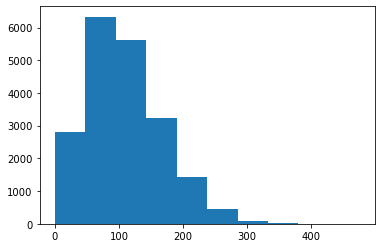

In [32]:
import matplotlib.pyplot as plt
plt.hist(dist_move.numpy(), bins = 10)

In [22]:
T_threshold = 1
T_range = 10
def getXInputValid(X_input_final):

    len_data, time_len = X_input_final.shape[:2]
    
    X_input_positive_cum_sum = torch.cumsum(X_input_final[..., 0] > 0, dim=-1)  # bsize. time_len
    X_input_positive_cum_sum[:, T_range:] = X_input_positive_cum_sum[:, T_range:] - X_input_positive_cum_sum[:,
                                                                                    :-T_range]

    X_input_valid = (X_input_positive_cum_sum - T_threshold) >= 0
    
    return X_input_valid  # (bsize, time_len, 1)

In [23]:
X_valid = getXInputValid(torch.tensor(X_input_final))

distance_map_final_temp = distance_map_final.copy()
distance_map_final_reshape = distance_map_final_temp.reshape((*distance_map_final_temp.shape[:-2], -1))
avg_map = distance_map_final_reshape.argmin(-1)
_, unique_map = np.unique(avg_map[X_valid], return_counts=True)

In [24]:
X_valid.shape

torch.Size([20000, 120])

In [25]:
torch.sum(X_valid)

tensor(799635)

In [26]:
np.set_printoptions(precision = 3)
unique_map.reshape(5,5)/np.sum(unique_map)

array([[0.025, 0.026, 0.031, 0.025, 0.027],
       [0.026, 0.04 , 0.063, 0.04 , 0.028],
       [0.035, 0.064, 0.129, 0.065, 0.035],
       [0.028, 0.04 , 0.064, 0.04 , 0.028],
       [0.026, 0.026, 0.034, 0.026, 0.025]])

In [42]:
np.set_printoptions(precision = 3)
unique_map.reshape(5,5)/np.sum(unique_map)

array([[0.021, 0.03 , 0.044, 0.031, 0.025],
       [0.037, 0.049, 0.061, 0.038, 0.034],
       [0.051, 0.061, 0.096, 0.049, 0.049],
       [0.032, 0.038, 0.046, 0.035, 0.034],
       [0.019, 0.027, 0.038, 0.029, 0.025]])

In [52]:
temp = np.array(range(80))
np.random.shuffle(temp)

In [53]:
temp

array([35, 31, 75, 55, 45, 16, 62, 22,  5, 26, 60, 56, 76, 47, 32, 19, 68,
       67, 44, 64, 39, 17, 78, 23, 43, 50,  8,  4,  7,  3,  9, 29, 18, 21,
       34, 14, 13, 70, 48, 69, 52, 12, 40, 41, 79, 61,  0, 33, 74, 36, 20,
       30, 54, 24, 38, 57, 25, 49, 71, 58, 15, 28, 72, 42, 63, 59,  2, 65,
       53, 46, 77, 27, 11,  6, 73, 10,  1, 66, 37, 51])

In [19]:
def getImgMask(crop_range, img_shape):
    # crop_range = (bsize, 2, 2)
    # image_shape = (bsize, 2, 2)
    img_top_left = crop_range[..., 0]
    img_bot_right = crop_range[..., 1]

    masks = []
    for i, img_size in enumerate(img_shape):
        values = torch.arange(0, img_size).view(
            (1,) * len(crop_range.shape[:-2]) + (img_size,)).to(crop_range.device)
        mask = (img_top_left[..., i, None] <= values) * (values < img_bot_right[..., i, None])
        mask = mask.unsqueeze(-1 - i)
        masks.append(mask)
    mask = reduce(op.and_, masks)
    return mask

In [20]:
import torch
map_prod = map_x* map_y
source_pos = torch.tensor(source_map_position)
bsize, time_len = source_map_position.shape[:2]

pos_map = torch.stack((torch.arange(map_prod) % map_y, map_y - 1 - torch.arange(map_prod) // map_y ), dim=-1).type(torch.float)
distance_map = torch.cdist(source_pos.type(torch.float), pos_map.type(torch.float)).reshape(bsize, time_len, map_x, map_y)
distance_map_final = distance_map.numpy().copy()[source_detect_mask]


In [21]:
temp_pos = torch.tensor([[1,3]])
temp = torch.cdist(temp_pos.type(torch.float), pos_map.type(torch.float))

In [22]:
source_map_position_final.shape

(14548, 120, 2)

In [23]:
source_map_pos_index = np.stack((map_y - 1 - source_map_position_final[..., 1], source_map_position_final[..., 0]), axis = -1)
source_map_pos_index.shape

(14548, 120, 2)

In [24]:
source_pos_index = torch.stack((map_y - 1 - source_pos[:1,0, 1], source_pos[:1,0, 0]), dim = -1)
source_pos_crop = torch.stack([source_pos_index, source_pos_index + 1], dim=-1)
mask = getImgMask(source_pos_crop, (5, 5))

In [27]:
torch.set_printoptions(precision=3, linewidth = 200)
distance_map[:1,0]

tensor([[[ 5.000,  5.099,  5.385,  5.831,  6.403,  7.071,  7.810,  8.602,  9.434, 10.296],
         [ 4.000,  4.123,  4.472,  5.000,  5.657,  6.403,  7.211,  8.062,  8.944,  9.849],
         [ 3.000,  3.162,  3.606,  4.243,  5.000,  5.831,  6.708,  7.616,  8.544,  9.487],
         [ 2.000,  2.236,  2.828,  3.606,  4.472,  5.385,  6.325,  7.280,  8.246,  9.220],
         [ 1.000,  1.414,  2.236,  3.162,  4.123,  5.099,  6.083,  7.071,  8.062,  9.055],
         [ 0.000,  1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000],
         [ 1.000,  1.414,  2.236,  3.162,  4.123,  5.099,  6.083,  7.071,  8.062,  9.055],
         [ 2.000,  2.236,  2.828,  3.606,  4.472,  5.385,  6.325,  7.280,  8.246,  9.220],
         [ 3.000,  3.162,  3.606,  4.243,  5.000,  5.831,  6.708,  7.616,  8.544,  9.487],
         [ 4.000,  4.123,  4.472,  5.000,  5.657,  6.403,  7.211,  8.062,  8.944,  9.849]]])

In [28]:
map_position_cropped = distance_map[:1,0][mask]
map_position_cropped

IndexError: The shape of the mask [1, 5, 5] at index 1 does not match the shape of the indexed tensor [1, 10, 10] at index 1

In [75]:
temp.reshape(1, 5, 5)

tensor([[[1.4142, 1.0000, 1.4142, 2.2361, 3.1623],
         [1.0000, 0.0000, 1.0000, 2.0000, 3.0000],
         [1.4142, 1.0000, 1.4142, 2.2361, 3.1623],
         [2.2361, 2.0000, 2.2361, 2.8284, 3.6056],
         [3.1623, 3.0000, 3.1623, 3.6056, 4.2426]]])

In [29]:
print(source_pos.shape)
print(source_map_position.shape)

torch.Size([17999, 120, 2])
(17999, 120, 2)


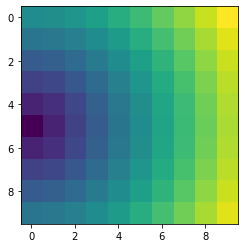

In [38]:
import matplotlib.pyplot as plt
shown_map = distance_map[0, 0].numpy()
plt.imshow(shown_map/np.sum(shown_map))

In [33]:
np.set_printoptions(precision=3, linewidth = 200)
distance_map_final[1, 0]

array([[8.062, 7.616, 7.28 , 7.071, 7.   , 7.071, 7.28 , 7.616, 8.062, 8.602],
       [7.211, 6.708, 6.325, 6.083, 6.   , 6.083, 6.325, 6.708, 7.211, 7.81 ],
       [6.403, 5.831, 5.385, 5.099, 5.   , 5.099, 5.385, 5.831, 6.403, 7.071],
       [5.657, 5.   , 4.472, 4.123, 4.   , 4.123, 4.472, 5.   , 5.657, 6.403],
       [5.   , 4.243, 3.606, 3.162, 3.   , 3.162, 3.606, 4.243, 5.   , 5.831],
       [4.472, 3.606, 2.828, 2.236, 2.   , 2.236, 2.828, 3.606, 4.472, 5.385],
       [4.123, 3.162, 2.236, 1.414, 1.   , 1.414, 2.236, 3.162, 4.123, 5.099],
       [4.   , 3.   , 2.   , 1.   , 0.   , 1.   , 2.   , 3.   , 4.   , 5.   ],
       [4.123, 3.162, 2.236, 1.414, 1.   , 1.414, 2.236, 3.162, 4.123, 5.099],
       [4.472, 3.606, 2.828, 2.236, 2.   , 2.236, 2.828, 3.606, 4.472, 5.385]], dtype=float32)

In [37]:
i_sample = 1
i_time_step = 0
for i_sample in range(5):
    print(source_pos[i_sample][i_time_step])
    print(source_map_position_index[i_sample][i_time_step])
    print(source_map_position[i_sample, i_time_step])
    print(agent_boundary[i_sample, i_time_step])

tensor([0, 4], dtype=torch.int32)
[5 0]
[0 4]
[[ -95  105]
 [-100  100]]
tensor([2, 6], dtype=torch.int32)
[3 2]
[2 6]
[[ -95  105]
 [-100  100]]
tensor([7, 4], dtype=torch.int32)
[5 7]
[7 4]
[[ -95  105]
 [-100  100]]
tensor([0, 4], dtype=torch.int32)
[5 0]
[0 4]
[[ -95  105]
 [-100  100]]
tensor([2, 9], dtype=torch.int32)
[0 2]
[2 9]
[[ -95  105]
 [-100  100]]


In [36]:
source_pos_index.shape

torch.Size([1, 2])

In [19]:
pos_map=pos_map.reshape(5, 5, 2)
pos_map[..., 0]

tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])

In [20]:
pos_map[..., 1]

tensor([[4., 4., 4., 4., 4.],
        [3., 3., 3., 3., 3.],
        [2., 2., 2., 2., 2.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.]])

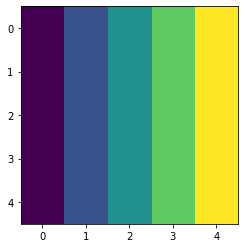

In [21]:
import matplotlib.pyplot as plt
plt.imshow(pos_map[...,0])

In [22]:
# import torch
# # map_prod = map_x* map_y
# # source_pos = torch.tensor(source_map_position)
# # bsize, time_len = source_map_position.shape[:2]

# # pos_map = torch.stack((torch.arange(map_prod) // map_y, torch.arange(map_prod) % map_y), dim=-1).type(torch.float)

# # map_distance = torch.cdist(source_pos.type(torch.float), pos_map.type(torch.float)).reshape(bsize, time_len, map_x, map_y)
# # distance_map_final = map_distance.numpy().copy()[source_detect_mask]

# pos_map = torch.zeros((map_x, map_y, 2))
# for i in range(map_x):
#     for j in range(map_y):
#         pos_map[i][j] = torch.tensor([j-map_y//2, map_y//2 - i])
# pos_map = pos_map.reshape(map_x * map_y, 2)
# bsize, time_len = X_input.shape[:2]
# map_distance = torch.cdist(torch.tensor(source_map_position).type(torch.float), pos_map.type(torch.float)).reshape(bsize, time_len, map_x, map_y)
# distance_map_final = map_distance.numpy().copy()[source_detect_mask]


# Create Distance Map

In [23]:
# import torch
# map_prod = map_x* map_y
# source_pos = torch.tensor(source_map_position)
# bsize, time_len = source_map_position.shape[:2]

# pos_map = torch.stack((torch.arange(map_prod) // map_y, torch.arange(map_prod) % map_y), dim=-1).type(torch.float)

# map_distance = torch.cdist(source_pos.type(torch.float), pos_map.type(torch.float)).reshape(bsize, map_x, map_y)
# distance_map_final = map_distance.unsqueeze(1).repeat(1,time_len,1, 1)

# mask_map = np.sum(detected_heat_map_final, axis = (-2, -1)) >0 
# distance_map_final = distance_map_final * mask_map[..., None, None]
# print(distance_map_final.shape)

In [24]:
def writeToFile(data, file_path):
    with open(file_path, 'wb') as f:
        x = pickle.dump(data, f)
        
def readFile(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)
    return data

path = "../output/data/processedData/updown/{}/".format(map_x)

X_input_path = path+"XInput.pkl"
detected_heat_map_path = path+"detectedHeatMap.pkl"
source_map_position_path = path+"sourceMapPosition.pkl"

X_input_final_path = path+"XInput_final.pkl"
# detected_heat_map_final_path = "../output/data/processedData/detectedHeatMap_final.pkl"
source_map_position_final_path = path+"sourceMapPosition_final.pkl"
# source_map_position_timelen_final_path = "../output/data/processedData/sourceMapPositionTimelen_final.pkl"
distance_map_final_path = path+"distance_map_final.pkl"
agent_action_final_path = path+"agent_action_final.pkl"
source_inside_final_path = path+"source_inside_final.pkl"

writeToFile(X_input, X_input_path)
# writeToFile(detected_heat_map, detected_heat_map_path)
writeToFile(source_map_position, source_map_position_path)

writeToFile(X_input_final, X_input_final_path)
# writeToFile(detected_heat_map_final, detected_heat_map_final_path)
writeToFile(source_map_position_final, source_map_position_final_path)
writeToFile(distance_map_final, distance_map_final_path)
# writeToFile(source_map_position_timelen_final, source_map_position_timelen_final_path)
writeToFile(agent_action_final, agent_action_final_path)
# writeToFile(source_inside_final, source_inside_final_path)


In [16]:
source_pos = source_map_position_final.copy()
source_inside = (source_pos[...,0]>=0) & (source_pos[...,0]<map_x) & (source_pos[...,1]>=0) & (source_pos[...,1]<map_y)
source_inside.shape

(14548, 120)

In [21]:
distance_map_final.shape

(14548, 120, 5, 5)

In [33]:
source_map_position_final = source_map_position[source_detect_mask]
source_position_final = source_position[source_detect_mask]
source_map_position_final.shape

(10548, 120, 2)

In [38]:
source_position_final.shape

(10548, 2)

In [31]:
source_map_position_final[1][0]

array([ 0, -1])

In [32]:
distance_map_final[1][0]

array([[3.6055512, 3.1622777, 3.       , 3.1622777, 3.6055512],
       [2.828427 , 2.236068 , 2.       , 2.236068 , 2.828427 ],
       [2.236068 , 1.4142135, 1.       , 1.4142135, 2.236068 ],
       [2.       , 1.       , 0.       , 1.       , 2.       ],
       [2.236068 , 1.4142135, 1.       , 1.4142135, 2.236068 ]],
      dtype=float32)

In [75]:
X_input_final[no_middle_pos_mask].shape

NameError: name 'no_middle_pos_mask' is not defined

In [55]:
middle_pos_1d = (map_x * map_y)//2
source_map_position_1d = source_map_position_final[... ,0] * map_y + source_map_position_final[..., 1]
source_map_position_1d.shape
source_middle_pos_mask = source_map_position_1d == middle_pos_1d

In [57]:
np.sum(source_middle_pos_mask.sum(axis = 1)>0)

2279

In [38]:
# drop middle data
middle_pos_1d = (map_x * map_y)//2
source_map_position_1d = source_map_position_final[:, 0 ,0] * map_y + source_map_position_final[:, 0, 1]
source_map_position_1d.shape
source_middle_pos_mask = source_map_position_1d == middle_pos_1d
no_middle_pos_mask = np.logical_not(source_middle_pos_mask)

# #apply mask
source_detect_final = source_detect_final[no_middle_pos_mask]
X_input_final = X_input_final[no_middle_pos_mask] 
# detected_heat_map_final = detected_heat_map[source_detect_mask] 
# water_flow_force_final = water_flow_force[source_detect_mask]
source_map_position_final = source_map_position_final[no_middle_pos_mask]
source_detect = source_detect[no_middle_pos_mask]
agent_action_final =agent_action_final[no_middle_pos_mask]
source_inside_final = source_inside_final[no_middle_pos_mask]

In [23]:
def getXInputValid(X_input_final, T):
    len_data = X_input_final.shape[0]
    threshold_T = 1#T // 2
    X_input_positive_cum_sum = torch.cumsum(X_input_final[..., 0] > 0, dim = -1) # bsize. time_len
    X_input_positive_cum_sum[:, threshold_T:] = X_input_positive_cum_sum[:, threshold_T:] - X_input_positive_cum_sum[:, :-threshold_T]

    X_input_valid = (X_input_positive_cum_sum - threshold_T) >= 0
    print(torch.sum(X_input_valid) / np.product(X_input_valid.numpy().shape))
    return X_input_valid.numpy()

In [24]:
X_valid = getXInputValid(torch.tensor(X_input_final), 5)

tensor(0.1932)


In [35]:
source_map_valid = source_map_position_final[X_valid]
# source_map_position_1d = (source_map_valid[...,0] + 30) * map_y + source_map_valid[..., 1] + 30
# source_map_position_1d.shape
source_map_valid.shape

(244517, 2)

In [26]:
source_map_mask = (np.abs(source_map_valid[:, 0]) <=(map_x//2 )) & (np.abs(source_map_valid[:, 1]) <=(map_y//2 ))

In [27]:
source_map_valid = source_map_valid[source_map_mask]
source_map_valid.shape

(98463, 2)

In [28]:
source_map_valid.shape

(98463, 2)

In [34]:
np.sum(temp[1])

98463

In [29]:
temp = np.unique(source_map_valid, axis = 0, return_counts=True)

In [36]:
np.set_printoptions(precision=3)
(temp[1]/len(source_map_valid)).reshape(5, 5)

array([[0.   , 0.001, 0.004, 0.004, 0.004],
       [0.001, 0.002, 0.007, 0.005, 0.006],
       [0.003, 0.005, 0.035, 0.018, 0.017],
       [0.002, 0.003, 0.027, 0.025, 0.037],
       [0.002, 0.005, 0.03 , 0.045, 0.116]])

In [37]:
np.sum(temp[1]/len(source_map_valid))

0.4026836579869702

In [21]:
pos, n_appear = np.unique(source_map_position_1d, return_counts=True)
pos_mask = (pos>=0) & (pos<map_x * map_y)
n_appear = n_appear[pos_mask]

In [22]:
np.set_printoptions(precision=2, suppress = True)
n_appear.reshape(map_x, map_y)/np.sum(n_appear)

ValueError: cannot reshape array of size 0 into shape (5,5)

In [ ]:
unique_rows = np.unique(original_array, axis=0)

In [85]:
temp = np.array([0.15, 0.2, 0.3, 0.2, 0.15])
distance_map_scale = np.atleast_2d(temp).T @ np.atleast_2d(temp)
distance_map_scale

array([[0.02, 0.03, 0.04, 0.03, 0.02],
       [0.03, 0.04, 0.06, 0.04, 0.03],
       [0.04, 0.06, 0.09, 0.06, 0.04],
       [0.03, 0.04, 0.06, 0.04, 0.03],
       [0.02, 0.03, 0.04, 0.03, 0.02]])

In [23]:
analize_distance_map = distance_map_final.copy()# * distance_map_scale[np.newaxis, np.newaxis,...]
analize_distance_map.reshape(-1, 5, 5).mean(axis = 0)


array([[4.46, 4.27, 4.23, 4.36, 4.67],
       [4.14, 3.94, 3.89, 4.02, 4.34],
       [4.03, 3.83, 3.77, 3.9 , 4.23],
       [4.15, 3.95, 3.9 , 4.03, 4.35],
       [4.48, 4.29, 4.25, 4.38, 4.69]], dtype=float32)

In [88]:
analize_distance_map.shape

(10548, 120, 5, 5)

In [89]:
distance_map_final.shape

(10548, 120, 5, 5)

In [83]:
X_input_final = torch.tensor(X_input_final)

In [84]:
T = 5
threshold_T = T // 2
X_input_positive_cum_sum = torch.cumsum(X_input_final[..., 0] > 0, dim = -1) # bsize. time_len
X_input_positive_cum_sum[:, threshold_T:] = X_input_positive_cum_sum[:, threshold_T:] - X_input_positive_cum_sum[:, :-threshold_T]

X_input_valid = (X_input_positive_cum_sum - threshold_T) >= 0

In [85]:
print(torch.sum(X_input_valid) / np.product(X_input_valid.numpy().shape))

tensor(0.2790)


In [59]:
X_input_positive_cumsum[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14, 14, 14,
       14, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45], dtype=int32)

In [61]:
X_input_valid = (X_input_positive_cumsum - threshold_T)>=0
np.sum(X_input_valid > 0)/np.product(X_input_valid.shape)

0.8443783353417111

In [46]:
X_valid_temp = np.zeros((X_input_valid.shape[0], T))
X_input_valid_final = np.concatenate((X_valid_temp, X_input_valid), axis = -1)
X_input_valid_final.shape

(11618, 80)

In [31]:
X_input_positive = X_input_final[...,0]>0
X_input_positive_cumsum = np.cumsum(X_input_positive, axis = -1)

In [19]:
a = torch.ones((3,1,2,3))
a.sum(dim = a.shape[1:]).shape[..., torch.new_axis]

AttributeError: module 'torch' has no attribute 'new_axis'

In [93]:
a = np.array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
ind = np.argpartition(a, -4)

In [94]:
ind

array([6, 9, 4, 3, 7, 2, 1, 5, 8, 0], dtype=int64)

# Create agent action

In [1]:
import numpy as np
from simulation.odorSimulation.aquaEnv import AquaEnv
from policy.QLearning import QLearning
from policy.QGammaLearning import QGammaLearning

env_arg = {
    # env_arg
    "mode": 1,
    "boundary": np.array([(0, 300), (-60, 60)]),  # boundary of environment
    "boundary_map": np.array([15, 15]),
    "time_step": 200,  # simulation time_length
    "total_map_x": 10,  # Heatmap resolution (10 x20)
    "total_map_y": 4,
    "map_x": 1,
    "map_y": 1,

    # water_flow
    "max_water_flow_force": 7,  # water_flow_force vector
    "min_water_flow_force": 3,  # water_flow_force vector
    "max_random_turbulence": 2,
    "random_water_flow": True,  # random_water_flow_force

    # training
    "episode_limit": 80,
    "feature_dim": 3,

    # reward design
    'success_reward': 300,
}

agent_arg = {
    "position": np.array([220, 0]),
    "dt": 5,
    "speed": 1,
    "radius": 10,

    # possible actions
    "directions": np.array([[0, -1], [0, 1]]), # up/down action, #np.array([[0, -1], [1, 0], [0, 1], [-1, 0]]),  
    "action_dim": 2,

    # initialize
    "random_start": False,
    "random_range": np.array([[0.4, 1], [0, 1]]),
    "random_direction": True,

}

source_arg = {
    "position": np.array([0, 0]),
    "dt": 1,
    "decay_rate": 0.97,
    "spawn_scale": 0.2,  # source produces "concentration/spawn scale" odor packets per time_step
    "size_scale": 1.05,
    "concentration_threshold": 0.3,
    
    # initialize
    "random_start": True,
    "random_range": np.array([[0.1, 0.7], [0.1, 0.9]]),
    "random_direction": True,
    "random_concentration": True,
    "min_concentration": 0.6,
    "max_concentration": 1.0,
    "burn_in": True,
}

wind_arg = {
    # Turbulence
    "energy": 0.2,
    "length_scale": 10,
    "tau_f": 5,
    "sampling_interval": 1 / 2,
}

env_arg['action_dim'] = agent_arg['action_dim']

# generate environment

env = AquaEnv(env_arg, agent_arg, source_arg, wind_arg)


15 80


In [2]:
save_list = [
             ("self.agent", "position"),
             ("self", "action"),
             ]
episode_data = env.getEpisodeData(save_list)

In [13]:
print(detected_heat_map_final.shape)
bsize, time_len, map_x, map_y = detected_heat_map_final.shape

(8635, 80, 10, 10)


In [364]:
np.round(detected_heat_map_final[3, -1, ...], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.87, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [365]:
np.round(detected_heat_map_final[3, -1, ...], 2).reshape(-1).reshape(10, 8)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.87, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [370]:
source_analysis = np.sum(detected_heat_map_final[:, -1]>0, axis = 0)

In [374]:
source_analysis.T[::-1]

array([[  0,  37,  41,  48,  53,  46,  63,   0,   0,   0],
       [  0, 131, 225, 219, 235, 247, 258,   0,   0,   0],
       [  0, 153, 190, 229, 281, 261, 245,   0,   0,   0],
       [  0, 135, 190, 276, 276, 249, 269,   0,   0,   0],
       [  0, 118, 198, 241, 245, 257, 253,   0,   0,   0],
       [  0, 140, 199, 268, 259, 276, 273,   0,   0,   0],
       [  0, 135, 212, 249, 255, 252, 263,   0,   0,   0],
       [  0,  18,  24,  36,  30,  37,  40,   0,   0,   0]])

In [372]:
source_analysis.reshape(-1).reshape((10, 8))

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [ 18, 135, 140, 118, 135, 153, 131,  37],
       [ 24, 212, 199, 198, 190, 190, 225,  41],
       [ 36, 249, 268, 241, 276, 229, 219,  48],
       [ 30, 255, 259, 245, 276, 281, 235,  53],
       [ 37, 252, 276, 257, 249, 261, 247,  46],
       [ 40, 263, 273, 253, 269, 245, 258,  63],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [346]:
values, counts = np.unique(source_location_analystic, return_counts=True)

In [379]:
np.sum(detected_heat_map_final>0)

614022

In [377]:
detected_heat_map_final.shape

(8635, 80, 10, 8)

In [299]:
source_map_position[source_detect_mask][12]

array([6, 5])

In [300]:
detected_heat_map_final[12][2].argmax()

53

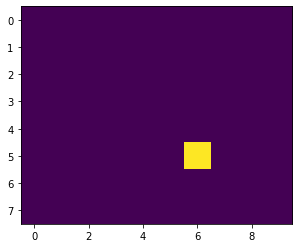

In [304]:
plt.imshow(detected_heat_map_final[12][2].T)

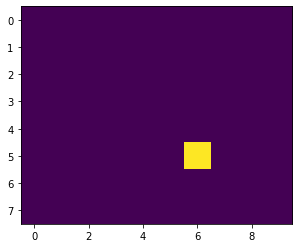

In [302]:

plt.imshow(detected_heat_map_final[12][2].swapaxes(0,1))

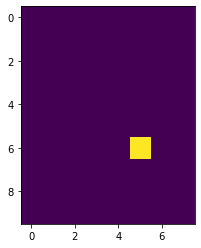

In [303]:
plt.imshow(detected_heat_map_final[12][2])

In [323]:
temp = np.zeros((5,4))
temp[-2, -2] = 1
temp[-2, -1] = 3
temp

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 3.],
       [0., 0., 0., 0.]])

In [324]:
temp.T[::-1]

array([[0., 0., 0., 3., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [309]:
temp.swapaxes(0,1)

array([[0, 2, 4],
       [1, 3, 5]])

In [3]:
import numpy as np
a = np.array([(0, 300), (-60, 60)])
a

array([[  0, 300],
       [-60,  60]])

In [51]:
def torchClip2D(in_map, out_map):
    # in_map = (bsize, 2, 2)
    # out_map = (2, 2)
    l = torch.atleast_2d(out_map[:, 0]).T
    r = torch.atleast_2d(out_map[:, 1]).T    
    overlap_boundary = torch.max(torch.min(in_map, r), l)
    return overlap_boundary
    
def getOverLapMapArea(global_boundary, local_boundary, global_map_boundary, local_map_boundary):
    # global_boundary = (2, 2)    
    # local_boundary = (bsize, 2, 2) #torch
    # global_map_boundary = 
    # local_map_boundary = (2, 2)
    
    #expected: 
    # global_map_range = (bsize, 2, 2)
    # local_map_range = (bsize, 2, 2)
    
    overlap_boundary = torch.clip(local_boundary, global_boundary) #(bsize, 2, 2)
    
    

In [90]:
import torch
local_boundary = torch.tensor([[[50,450], [-125, 275] ], [[50,450], [1600, 2000]], [[50,450], [-125, 275] ]])
global_boundary = torch.tensor([[0,300], [0, 100]])

local_map_boundary = torch.tensor([[0, 16], [0,16]])
global_map_boundary = torch.tensor([[0, 12], [0,4]])

local_shape = torch.tensor([16, 16])
global_shape = torch.tensor([12, 4])


In [91]:
def getMapRange(mapping_boundary, boundary, map_boundary):
    interval = (boundary[..., 1] - boundary[..., 0]) // (map_boundary[..., 1] - map_boundary[..., 0])


    r_map_boundary = (mapping_boundary[..., 1] - boundary[..., 0]) // interval
    l_map_boundary = (mapping_boundary[..., 0] - boundary[..., 0]) // interval
    result_map_boundary = torchClip2D(torch.stack([l_map_boundary, r_map_boundary], dim = 2), map_boundary)
    return result_map_boundary

In [92]:
overlap_boundary = torchClip2D(local_boundary, global_boundary)
local_crop_range = getMapRange(overlap_boundary, local_boundary, local_map_boundary)
global_crop_range = getMapRange(overlap_boundary, global_boundary, global_map_boundary)

In [93]:
local_crop_range.shape

torch.Size([3, 2, 2])

In [94]:
import numpy as np
bsize = 3
local_heat_map = torch.arange(bsize * np.product(local_shape.numpy())).reshape((bsize, *local_map_boundary[..., 1])).type(torch.float)
global_heat_map = torch.zeros((bsize, *global_map_boundary[..., 1])).type(torch.float)

print(local_heat_map.shape)
print(global_heat_map.shape)

torch.Size([3, 16, 16])
torch.Size([3, 12, 4])


In [95]:
torch.set_printoptions(edgeitems = 10, linewidth=100,profile='full')


In [96]:
import operator as op
from functools import reduce

def getImgMask(crop_range, img_shape):
    # crop_range = (bsize, 2, 2)
    # image_shape = ( 2)
    img_top_left = crop_range[... , 0]
    img_bot_right = crop_range[..., 1]

    masks = []
    for i, img_size in enumerate(img_shape):
        values = torch.arange(0, img_size).view(
            (1,) * len(crop_range.shape[:-2]) + (img_size,))
        mask = (img_top_left[..., i, None] <= values) * (values < img_bot_right[..., i, None])
        print(mask.shape)
        mask = mask.unsqueeze(-1 - i)
        print(mask.shape)
        masks.append(mask)
    mask = reduce(op.and_, masks)
    return mask

In [97]:
local_shape = local_map_boundary[..., 1] - local_map_boundary[..., 0]
global_shape = global_map_boundary[..., 1] - global_map_boundary[..., 0]
local_mask = getImgMask(local_crop_range, local_shape)
print(local_mask.shape, local_heat_map.shape)
global_mask = getImgMask(global_crop_range, global_shape)
print(global_mask.shape, global_heat_map.shape)

global_heat_map[global_mask] = local_heat_map[local_mask]

torch.Size([3, 16])
torch.Size([3, 16, 1])
torch.Size([3, 16])
torch.Size([3, 1, 16])
torch.Size([3, 16, 16]) torch.Size([3, 16, 16])
torch.Size([3, 12])
torch.Size([3, 12, 1])
torch.Size([3, 4])
torch.Size([3, 1, 4])
torch.Size([3, 12, 4]) torch.Size([3, 12, 4])


In [98]:
directions = torch.tensor([[0, -1], [0, 1], [-1, 0], [1, 0]])
action = torch.tensor([[1], [2], [0]])
position = torch.zeros(3, 2)
directions[action]

new_position = position + directions[action.squeeze()]
new_position

tensor([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.]])

In [99]:
distance = 1
half_distance = 0.5
position = position + directions[action.squeeze(1)]
print(position)
map_action = (np.abs(position) > half_distance) * np.sign(position)

position = position - map_action * distance
print(position)

tensor([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


tensor([10,  4])

In [142]:
a = None
a = torch.tensor([1,2,3])
if a :
    print("asd")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [143]:
local_crop_range.shape

torch.Size([3, 2, 2])

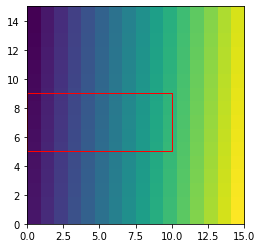

In [138]:
fig, ax = plt.subplots()
local_show_map = local_heat_map[0]/torch.max(local_heat_map[0])
ax.imshow(local_show_map.T, extent=[0,15,0,15])
# ax.invert_yaxis()
local_crop_shape = (local_crop_range[0][:, 1] - local_crop_range[0][:, 0]).numpy()
rect = patches.Rectangle(local_crop_range[0][:, 0].numpy(), local_crop_shape[0], local_crop_shape[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

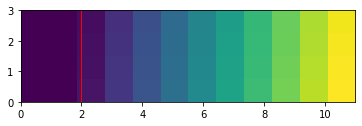

In [139]:
fig, ax2 = plt.subplots()
global_show_map = global_heat_map[0]/ torch.max(local_heat_map[0])
ax2.imshow(global_show_map.T, extent=[0,11,0, 3])
# ax2.invert_yaxis()
global_crop_shape = (global_crop_range[0][:, 1] - global_crop_range[0][:, 0]).numpy()
rect1 = patches.Rectangle(global_crop_range[0][:, 0].numpy(), global_crop_shape[0], global_crop_shape[1], linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect1)
plt.show()

In [124]:
global_show_map.shape

torch.Size([12, 4])

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [218]:
torch.set_printoptions(edgeitems = 10, linewidth=120,profile='full')
print(local_heat_map[0])
print(global_heat_map[0])

tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.],
        [ 16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.],
        [ 32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.],
        [ 48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.],
        [ 64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.],
        [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.],
        [ 96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.],
        [112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.],
        [128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.],
        [144., 145., 146., 147., 148., 149., 1

In [177]:
def forward(self, obs, action, hidden, get_all = False):
    # obs = (bsize, time_len, feature_dim)
    # action = (bsize, time_len, 1)
    # hidden = (bsize, mem_size, mem_size, feature_dim)
    bsize, time_len, feature_dim = obs.shape

    all_mem = []

    for i_time_step in range(time_len):
        self.updateMapPosition(action[:, i_time_step])
        current_mem = self.getUpdatedMem(obs[:, i_time_step], hidden)
        previous_mem = hidden.clone()

        mem = current_mem * self.mu + (1 - self.mu) * previous_mem
        hidden = mem.clone()  # (bsize, k_tap, k_tap, feature_dim)

        mem = torch.movedim(mem, -1, -3)  # (bsize, feature_dim, k_tap, k_tap)
        all_mem.append(mem)

    if get_all:
        mem = torch.stack(all_mem, dim = 1) #(bsize, time_len, feature_dim, k_tap, k_tap)

    return mem, hidden

tensor([[[ 5,  9],
         [ 0, 10]],

        [[ 0,  0],
         [ 0, 10]],

        [[ 5,  9],
         [ 0, 10]]])

In [240]:
local_boundary

tensor([[[-125,  275],
         [  50,  450]],

        [[1600, 2000],
         [  50,  450]],

        [[-125,  275],
         [  50,  450]]])

In [155]:
global_mask.shape

torch.Size([3, 30, 10])

In [242]:
t = torch.tensor([[[1, 2],[3, 4]],[[5, 6],[7, 8]]])
t.shape

torch.Size([2, 2, 2])

In [244]:
torch.flatten(t, start_dim = -2).shape

torch.Size([2, 4])

In [247]:
temp_bool = torch.tensor([[[0], [1]], [[1], [1]]]).type(torch.bool)
temp_bool.shape

torch.Size([2, 2, 1])

In [253]:
a = torch.arange(12).reshape(2, 2, 1, 3)
b = torch.arange(12).reshape(2, 2, 1, 3) * 3

c = torch.where(temp_bool, a, b)
c

tensor([[[[ 0,  3,  6],
          [ 0,  1,  2]],

         [[ 3,  4,  5],
          [ 3,  4,  5]]],


        [[[18, 21, 24],
          [ 6,  7,  8]],

         [[ 9, 10, 11],
          [ 9, 10, 11]]]])

In [254]:
c.shape

torch.Size([2, 2, 2, 3])